In [1]:
!pip install uproot awkward 
!pip install xgboost
from uproot_io import Events, View
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import joblib

#cheated_5 = Events("CheatedRecoFile_1_new.root") # testing

  Using cached uproot-5.6.0-py3-none-any.whl.metadata (34 kB)
  Using cached awkward-2.7.4-py3-none-any.whl.metadata (7.0 kB)
  Using cached cramjam-2.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached awkward_cpp-44-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
Using cached uproot-5.6.0-py3-none-any.whl (365 kB)
Using cached awkward-2.7.4-py3-none-any.whl (871 kB)
Using cached awkward_cpp-44-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (638 kB)
Using cached cramjam-2.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.4 MB)
  Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.25.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.8 kB)
Using cached xgboost-2.1.4-py3-none-manylinux_2_28_x86_64.whl (223.6 MB)
Using cached nvidia_nccl_cu12-2.25.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (201

In [6]:
""" BDT Training and event classification """

from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy import stats
import gc

plt.rcParams.update({'font.size': 12})

model = joblib.load("optimized_15f.pkl")

importances = model.feature_importances_
feature_names = [
    'Correlation',
    'DBSCAN Noise',
    'Best Fit RMSE',
    'Angle',
    'Line',
    'ADC Q4',
    'Step Length',
    r'$\text{Initial } \frac{dE}{dr}$',
    'Hit Count',
    'ADC Sum',
    'Hull Density',
    'Curvature',
    'ADC Per Hit',
    'ADC Max Norm',
    'Scatter Momentum'
]



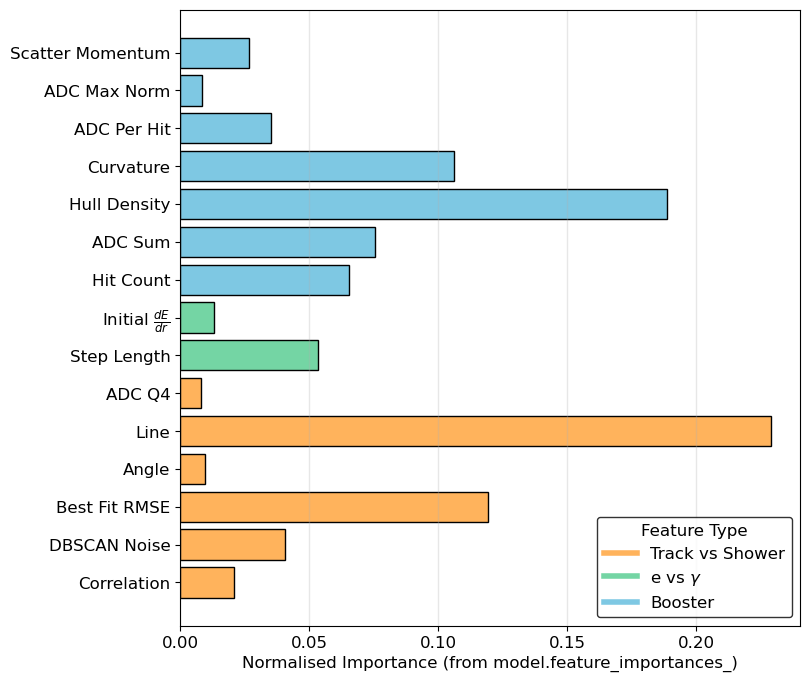

In [7]:
feature_types = [
    'Track vs Shower',
    'Track vs Shower',
    'Track vs Shower',
    'Track vs Shower',
    'Track vs Shower',
    'Track vs Shower',
    r'e vs $\gamma$',
    r'e vs $\gamma$',
    'Booster',
    'Booster',
    'Booster',
    'Booster',
    'Booster',
    'Booster',
    'Booster',
]

feature_colours = {
    'Track vs Shower': '#ffb35c',
    r'e vs $\gamma$': '#74d5a4',
    'Booster': '#7ec8e3',
}

bar_colours = [feature_colours[ftype] for ftype in feature_types]

plt.figure(figsize=(8, 8))
bars = plt.barh(np.arange(len(importances)), importances, color=bar_colours, edgecolor='k')
plt.yticks(np.arange(len(importances)), feature_names)
plt.xlabel('Normalised Importance (from model.feature_importances_)')

unique_feature_types = list(feature_colours.keys())
legend_patches = [plt.Line2D([0], [0], color=feature_colours[ftype], lw=4, label=ftype) for ftype in unique_feature_types]
plt.legend(handles=legend_patches, title="Feature Type", loc="lower right", frameon=True, edgecolor='black')
plt.grid(visible=True, which='major', axis='x', linestyle='-', linewidth=1.0, alpha=0.3)
plt.show()

In [4]:
data = np.load("15f_testing.npz", allow_pickle=True)
x_test = data["x_test"]
y_test = data["y_test"][:, 1]
indices = data["y_test"][:, 0]

# Step 3: Extract Confidence Values (no need for predictions now)
preds = model.predict(x_test)

print(f'Labels in preds: {np.unique(preds)}\npreds looks like: {preds[:50]}...\npreds has shape: {preds.shape}')

Labels in preds: [0 1 2 3]
preds looks like: [3 1 1 1 2 0 3 3 0 1 2 0 0 0 0 0 1 1 3 3 0 0 0 0 1 1 1 1 1 1 2 1 1 0 0 1 1
 1 1 3 0 0 1 0 0 3 2 1 1 1]...
preds has shape: (49615,)


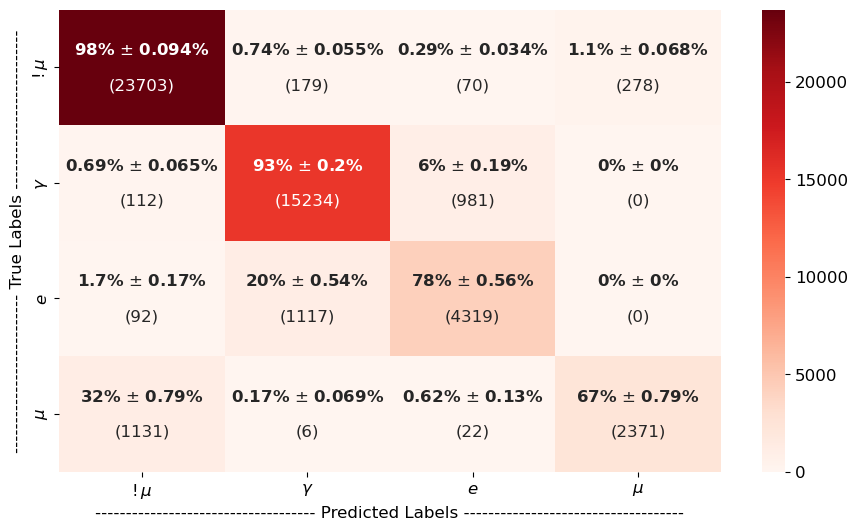

91.96210823339716
0.12205878387863828


In [5]:
# Look how accurate the by particle predictions were

cm = confusion_matrix(y_test, preds)

particle_labels = [r'$!\mu$', r'$\gamma$', r'$e$', r'$\mu$']
def eff(m, n):
    return m/n

def uncertainty(m, n):
    return np.sqrt(eff(m, n) * (1 - eff(m, n))/n)

# Create efficiency and uncertainty arrays
eff_matrix = np.zeros_like(cm, dtype=float)
uncertainty_matrix = np.zeros_like(cm, dtype=float)

# Fill the matrices with efficiency and uncertainty
for i in range(len(particle_labels)):
    for j in range(len(particle_labels)):
        total = np.sum(cm[i])  # Total for the true class (row sum)
        true_positive = cm[i, j]  # True positives (diagonal element)
        
        if total > 0:
            eff_matrix[i, j] = eff(true_positive, total)
            uncertainty_matrix[i, j] = uncertainty(true_positive, total)

# Create formatted labels that include efficiency + uncertainty and tally
formatted_values = []
for i in range(len(particle_labels)):
    row = []
    for j in range(len(particle_labels)):
        eff_val = r'$\mathbf{' + f'{eff_matrix[i, j]*100:.2g}' + r'\%}$'
        unc_val = r'$\mathbf{' + f'{uncertainty_matrix[i, j]*100:.2g}' + r'\%}$'
        tally = f'({cm[i, j]})'  # Raw count
        
        # Combine efficiency, uncertainty, and tally
        formatted_string = f'{eff_val} $\pm$ {unc_val}\n\n{tally}'
        row.append(formatted_string)
    formatted_values.append(row)

# Plotting the confusion matrix with efficiency, uncertainty, and tally
plt.figure(figsize=(8*(4/3), 6))

sns.heatmap(cm, annot=formatted_values, fmt='', cmap='Reds', 
            xticklabels=particle_labels, yticklabels=particle_labels)

plt.xlabel('------------------------------------ Predicted Labels ------------------------------------')
plt.ylabel('-------------------------- True Labels --------------------------')
plt.show()

print(eff(np.trace(cm), np.sum(cm))*100)
print(uncertainty(np.trace(cm), np.sum(cm))*100)

In [6]:
"""
Now, need to divide predictions into events
"""
identifiers = cheated_5.event_number
change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
slices = np.split(np.arange(len(cheated_5.event_number)), change_indices)
testing_slices = [slice_array[np.isin(slice_array, indices)] for slice_array in slices]
testing_slices = [s for s in testing_slices if s.size > 0]

print(f'Event slices look like: {testing_slices[:10]}')

Event slices look like: [array([ 0, 69, 70, 88, 89, 91]), array([97]), array([137, 138, 174, 175, 176, 180, 252, 254, 270, 290, 291]), array([292]), array([312]), array([314, 315, 324, 329, 348, 349, 350, 351, 352, 353, 354, 355, 356,
       358, 369, 389, 390, 391, 392, 407, 497, 529, 538]), array([539, 560, 576, 582, 583, 584, 585]), array([586]), array([605, 606]), array([612, 613, 678])]


In [7]:
split_preds = []
start = 0

for subarray in testing_slices:
    length = len(subarray)
    split_preds.append(preds[start:start+length])
    start += length

# Now split_preds has the same shape as testing_slices
print(split_preds[:10])
print(f'Total no. sliced preds: {len(split_preds)}')
print(testing_slices[:10])
print(f'Total no. slices{len(testing_slices)}')

[array([3, 1, 1, 1, 2, 0]), array([3]), array([3, 0, 1, 2, 0, 0, 0, 0, 0, 1, 1]), array([3]), array([3]), array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 3, 0, 0,
       1]), array([0, 0, 3, 2, 1, 1, 1]), array([3]), array([3, 0]), array([3, 0, 2])]
Total no. sliced preds: 8602
[array([ 0, 69, 70, 88, 89, 91]), array([97]), array([137, 138, 174, 175, 176, 180, 252, 254, 270, 290, 291]), array([292]), array([312]), array([314, 315, 324, 329, 348, 349, 350, 351, 352, 353, 354, 355, 356,
       358, 369, 389, 390, 391, 392, 407, 497, 529, 538]), array([539, 560, 576, 582, 583, 584, 585]), array([586]), array([605, 606]), array([612, 613, 678])]
Total no. slices8602


In [8]:
def is_primary_in_testset(events, test_indices):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
    slices = np.split(np.arange(len(identifiers)), change_indices)  # Groups indices by event
    
    # Find the subarray that contains test indices
    event_idx_array = next((sub for sub in slices if test_indices[0] in sub), None)
    
    # find nu_vtx and particle_vtx of all indices in idx_array
    nu_vtx_w = events.neutrino_vtx_w[event_idx_array]
    nu_vtx_x = events.neutrino_vtx_x[event_idx_array]
    idx_w_vtx = events.reco_particle_vtx_w[event_idx_array]
    idx_x_vtx = events.reco_particle_vtx_x[event_idx_array]

    w_distances = idx_w_vtx - nu_vtx_w
    x_distances = idx_x_vtx - nu_vtx_x

    abs_distances = np.sqrt(w_distances**2 + x_distances**2)

    min_distance = np.min(abs_distances)
    min_distance_indices = event_idx_array[np.where(abs_distances == min_distance)[0]]

    if any(test_idx in min_distance_indices for test_idx in test_indices):
        return True
    else: return False

event_labels_pred = []

for j in range(len(split_preds)):
    preds = split_preds[j]
    pred_indices = testing_slices[j]

    mu_mask = np.where(preds == 3)[0]
    e_mask = np.where(preds == 2)[0]

    mu_indices = pred_indices[mu_mask]
    e_indices = pred_indices[e_mask]
    if len(mu_indices) != 0 and is_primary_in_testset(cheated_5, mu_indices):
        event_labels_pred.append(2) # if primary muon predicted
    elif len(e_indices) != 0 and is_primary_in_testset(cheated_5, e_indices):
        event_labels_pred.append(1) # if primary electron detected
    else: event_labels_pred.append(0) # NCnu_x

print(event_labels_pred[:50])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0]


In [9]:
print(event_labels_pred[:50])
print(len(event_labels_pred))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2, 0]
8602


In [10]:
event_labels_true = []

for k in range(len(testing_slices)):
    isnumu = cheated_5.is_numu[testing_slices[k]].any()
    isnue = cheated_5.is_nue[testing_slices[k]].any()
    if isnumu and isnue: # rare cases when the file chooses both, want to assign to NC
        event_labels_true.append(0)
    elif isnumu:
        event_labels_true.append(2)
    elif isnue:
        event_labels_true.append(1)
    else: event_labels_true.append(0)

print(event_labels_true[:50])
print(len(event_labels_true))

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2]
8602


In [11]:
conf_matrix = confusion_matrix(event_labels_true, event_labels_pred)

print("Confusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(event_labels_true, event_labels_pred)

print("Accuracy Score:", accuracy)

Confusion Matrix:
[[1613  128   64]
 [ 598 2820   79]
 [ 958   61 2281]]
Accuracy Score: 0.780516159032783


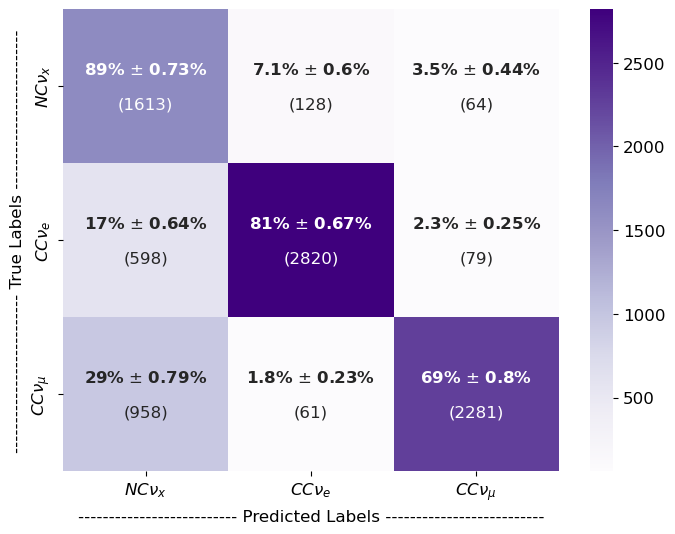

In [12]:
event_classes = [r'$NC\nu_x$', r'$CC\nu_e$', r'$CC\nu_\mu$']

def eff(m, n):
    return m/n

def uncertainty(m, n):
    return np.sqrt(eff(m, n) * (1 - eff(m, n))/n)

# Create efficiency and uncertainty arrays
eff_matrix = np.zeros_like(conf_matrix, dtype=float)
uncertainty_matrix = np.zeros_like(conf_matrix, dtype=float)

# Fill the matrices with efficiency and uncertainty
for i in range(len(event_classes)):
    for j in range(len(event_classes)):
        total = np.sum(conf_matrix[i])  # Total for the true class (row sum)
        true_positive = conf_matrix[i, j]  # True positives (diagonal element)
        
        if total > 0:
            eff_matrix[i, j] = eff(true_positive, total)
            uncertainty_matrix[i, j] = uncertainty(true_positive, total)

# Create formatted labels that include efficiency + uncertainty and tally
formatted_values = []
for i in range(len(event_classes)):
    row = []
    for j in range(len(event_classes)):
        eff_val = r'$\mathbf{' + f'{eff_matrix[i, j]*100:.2g}' + r'\%}$'
        unc_val = r'$\mathbf{' + f'{uncertainty_matrix[i, j]*100:.2g}' + r'\%}$'
        tally = f'({conf_matrix[i, j]})'  # Raw count
        
        # Combine efficiency, uncertainty, and tally
        formatted_string = f'{eff_val} $\pm$ {unc_val}\n\n{tally}'
        row.append(formatted_string)
    formatted_values.append(row)

# Plotting the confusion matrix with efficiency, uncertainty, and tally
plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=formatted_values, fmt='', cmap='Purples', 
            xticklabels=event_classes, yticklabels=event_classes)

plt.xlabel('-------------------------- Predicted Labels --------------------------')
plt.ylabel('-------------------------- True Labels --------------------------')
plt.show()

In [13]:
print(eff(np.trace(conf_matrix), np.sum(conf_matrix))*100)
print(uncertainty(np.trace(conf_matrix), np.sum(conf_matrix))*100)

78.0516159032783
0.4462646702563018
